In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
from scipy.ndimage import gaussian_filter1d


In [71]:

# Read all the data files from a selected folder
def read_data_files(folder):
    print("reading data...")
    data_files = os.listdir(folder)                             # List all files in the folder
    # print(data_files)
    data_files = [f for f in data_files if f.endswith('.csv')]  # Keep only the csv files
    data = np.zeros(len(data_files), dtype=object)              # Create an array to store the data                                 
    for i in range(len(data_files)):
        data[i] = pd.read_csv(folder + '/' + data_files[i])     # Read the data files
    return data#, data_files

def plot_runs(data, extra_data, extra_labels):
    print("plotting data...")
    plt.figure(figsize=(12, 6))
    for run in data:
        cols = run.columns
        run_name = cols[0].split("_")[-1]
        plt.plot(run[cols[0]], run[cols[1]], label=f"Run {run_name}")
    i = 0
    if extra_data is not None:
        for extra in extra_data:
            plt.plot(extra[extra.columns[0]], extra[extra.columns[1]], ls='--', label=extra_labels[i])
            i = i + 1
    plt.xlabel("B-Field [T]")
    plt.ylabel("Voltage [V]")
    plt.title("Plot of All Test Runs")
    plt.legend()
    plt.grid()
    # plt.savefig("all_runs.png", dpi=800)
    plt.show()
    

reading data...
plotting data...


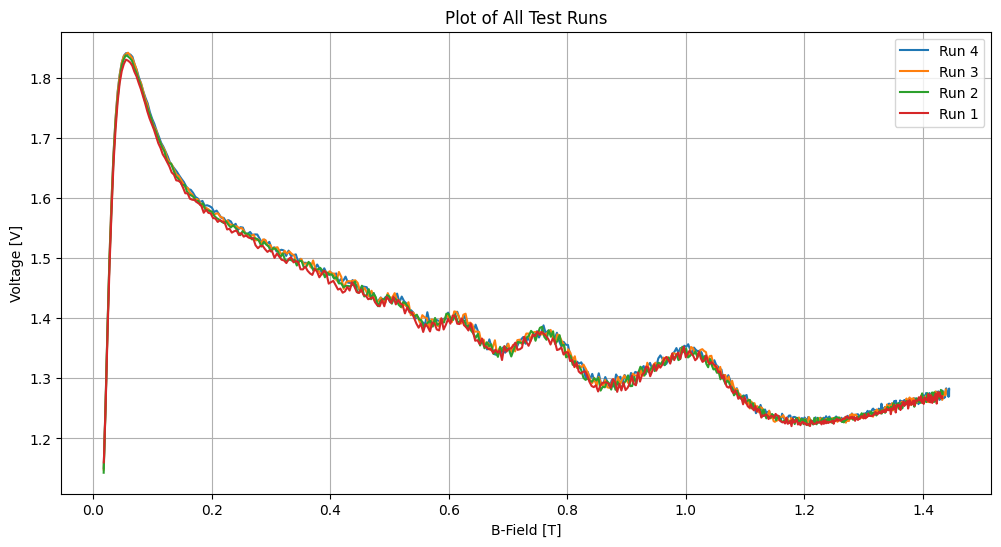

In [72]:

df_array = read_data_files("test_data")

plot_runs(df_array, None, None)


Data Shape of Avg: (501, 2)
Data Type of Avg: <class 'pandas.core.frame.DataFrame'>


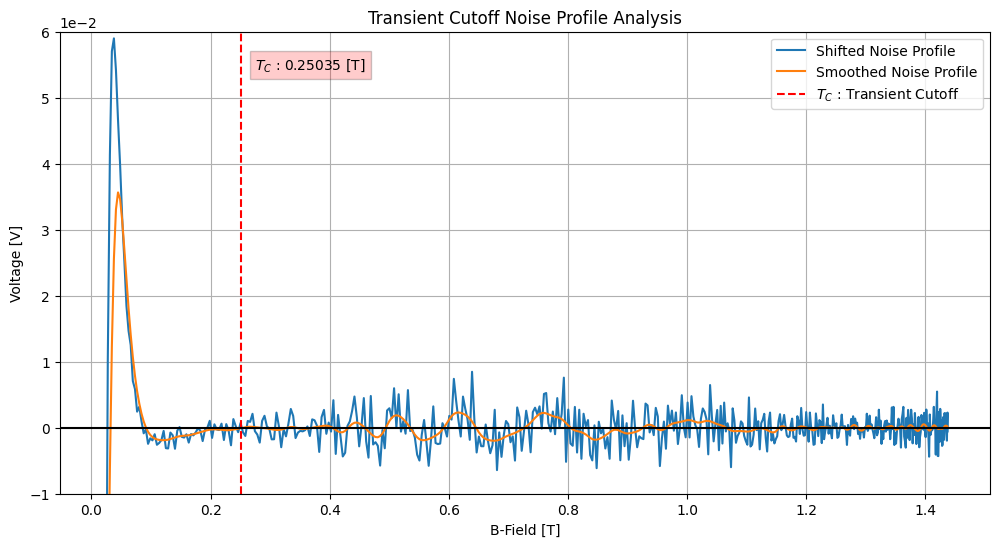

Data Shape of Avg: (438, 2)


In [73]:
# Constants
const_current = 10/500 # 10V / 500 Ohm | should be 20mA
x_section_sample = 2e-6 # m^2 | 2 #mm^2
length_sample = 0.015 # m | 1.5 #cm
omega_0 = 42.2 # Hz
conversion_factor = x_section_sample / (length_sample * const_current) # V / T

# Error
gauss_meter_err = 0.002 # 0.20% error | Lake Shore 425 Gaussmeter
lockin_err = 0.2 # 2% error | SR530 Lock-In Amplifier | THIS NEEDS TO BE CONFIRMED MANUAL PG29


def average_runs(data):
    
    num_runs = len(data)
    
    # Unpack the data into numpy arrays
    field_data = np.array([run.values[:,0] for run in data])
    volt_data = np.array([run.values[:,1] for run in data])
    
    # Get system error from the standard error of the mean and the instrument error
    field_err = (np.std(field_data, axis=0) / np.sqrt(num_runs))
    volt_err = (np.std(volt_data, axis=0) / np.sqrt(num_runs))
    
    # Average the data and put it into an uncertainties array
    avg_field_un = unp.uarray(np.mean(field_data, axis=0), field_err)
    avg_volt_un = unp.uarray(np.mean(volt_data, axis=0), volt_err)
    
    avg = pd.DataFrame({"Magnetic Field (T)": avg_field_un, "Voltage (V)": avg_volt_un})
    
    return avg


avg_data = average_runs(df_array)

print("Data Shape of Avg:", avg_data.shape)
print("Data Type of Avg:", type(avg_data))
# print(avg_data.to_markdown())

# =================================================================================================

# Find the noise floor
avg_data_field_nom = unp.nominal_values(avg_data[avg_data.columns[0]])
noise_check = unp.nominal_values(avg_data[avg_data.columns[1]]) - gaussian_filter1d(unp.nominal_values(avg_data[avg_data.columns[1]]), 3)
noise_check_smooth = gaussian_filter1d(noise_check, 3)

# Find zero crossings of the slope
zero_crossings = np.where(np.diff(np.sign(noise_check_smooth)))[0]
transient_cutoff = avg_data_field_nom[zero_crossings[2]] # The first zero crossing after the noise floor
# print(avg_data_field_nom[zero_crossings])

plt.figure(figsize=(12, 6))
plt.plot(avg_data_field_nom, noise_check, label="Shifted Noise Profile")
plt.plot(avg_data_field_nom, noise_check_smooth, label="Smoothed Noise Profile")

plt.axvline(transient_cutoff, color='r', ls='--', label="$T_C$ : Transient Cutoff")
plt.axhline(0, color='k', ls='-')

plt.text(transient_cutoff - 0.04, 0.92, "$T_C$ : " + str(transient_cutoff) + " [T]", fontsize=10, transform=plt.gca().transAxes, bbox=dict(facecolor='r', alpha=0.2))

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("B-Field [T]")
plt.ylabel("Voltage [V]")
plt.ylim(-0.01, 0.06)
plt.title("Transient Cutoff Noise Profile Analysis")
plt.legend()
plt.grid()
# plt.savefig("noise_profile.png", dpi=800)
plt.show()

# =================================================================================================

# Drop the values before 0.2 T | This is just initialization transience
avg_data = avg_data[avg_data["Magnetic Field (T)"] > transient_cutoff]
avg_data = avg_data.reset_index(drop=True)
print("Data Shape of Avg:", avg_data.shape)


In [74]:
# This is to remove the datas quadratic component

# Fit a quadratic to the average data
def fit_data(data, order):
    x = unp.nominal_values(data[data.columns[0]])
    y = unp.nominal_values(data[data.columns[1]])
    
    fit, cov = np.polyfit(x, y, order, cov=True)
    fit_err = np.sqrt(np.diag(cov))
    
    return unp.uarray(fit, fit_err)

avg_data[avg_data.columns[1]] = conversion_factor * avg_data[avg_data.columns[1]] # Convert the voltage to d(rho)/dB
avg_fit = fit_data(avg_data, 2)
print(f"Fit: ({avg_fit[0]}) * B^2 + ({avg_fit[1]}) * B + ({avg_fit[2]})")

# Remove the quadratic component from the averaged data
quad_comp = avg_fit[0] * avg_data[avg_data.columns[0]]**2 + avg_fit[1] * avg_data[avg_data.columns[0]] + avg_fit[2]

avg_deline_data = avg_data.copy()
avg_deline_data[avg_deline_data.columns[1]] = (avg_deline_data[avg_deline_data.columns[1]] - quad_comp)


# print("Data Shape of Deline:", avg_deline_data)
# print("Data Shape of Deline:", avg_data)


Fit: (0.00144+/-0.00007) * B^2 + (-0.00407+/-0.00012) * B + (0.01121+/-0.00005)


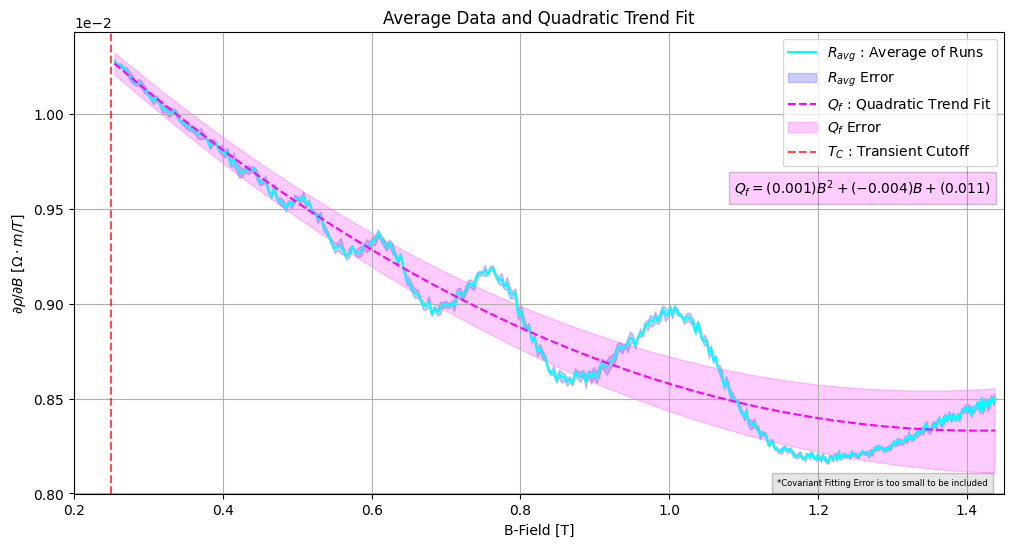

In [75]:
fig = plt.figure(figsize=(12, 6))

avg_field_nom = unp.nominal_values(avg_data[avg_data.columns[0]])
avg_volt_nom = unp.nominal_values(avg_data[avg_data.columns[1]])

avg_field_err = unp.std_devs(avg_data[avg_data.columns[0]])
avg_volt_err = unp.std_devs(avg_data[avg_data.columns[1]])

avg_fit_nom = unp.nominal_values(avg_fit)
avg_fit_err = unp.std_devs(avg_fit)

quad_comp_nom = unp.nominal_values(quad_comp)
quad_comp_err = unp.std_devs(quad_comp)

# quad_comp_str = (f"$Q_f = ({avg_fit_nom[0]:.3f}$" + r"$\pm$" + f"$({avg_fit_err[0]:.3e})) B^{2} + ({avg_fit_nom[1]:.3f}$" 
#                  + r"$\pm$" + f"${avg_fit_err[1]:.3f}) B + ({avg_fit_nom[2]:.3f}$" + r"$\pm$" + f"${avg_fit_err[2]:.3f})$")

quad_comp_str = (f"$Q_f = ({avg_fit_nom[0]:.3f}) B^{2} + ({avg_fit_nom[1]:.3f}) B + ({avg_fit_nom[2]:.3f})$")

# plt.plot(df_array[0].values[:,0], df_array[0].values[:,1], color='blue', label="Run 1")
# plt.fill_between(df_array[0].values[:,0], df_array[0].values[:,1] * (1 - lockin_err), df_array[0].values[:,1] * (1 + lockin_err), color='blue', alpha=0.2)

plt.plot(avg_field_nom, avg_volt_nom, color='cyan', ls='-', label="$R_{avg}$ : Average of Runs")
plt.fill_between(avg_field_nom, avg_volt_nom - avg_volt_err, avg_volt_nom + avg_volt_err, color='b', label="$R_{avg}$ Error", alpha=0.2)

plt.plot(avg_field_nom, quad_comp_nom, color='magenta', ls='--', label="$Q_f$ : Quadratic Trend Fit")
plt.fill_between(avg_field_nom, quad_comp_nom - quad_comp_err, quad_comp_nom + quad_comp_err, color='magenta', label="$Q_f$ Error", alpha=0.2)

plt.axvline(transient_cutoff, color='r', ls='--', alpha=0.7, label=f"$T_C$ : Transient Cutoff")
plt.text(0.71, 0.65, quad_comp_str, fontsize=10, transform=plt.gca().transAxes, bbox=dict(facecolor='magenta', alpha=0.2))
plt.text(0.756, 0.017, f"*Covariant Fitting Error is too small to be included", fontsize=6, transform=plt.gca().transAxes, bbox=dict(facecolor='grey', alpha=0.2))

plt.xlim(0.2, 1.45)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("B-Field [T]")
plt.ylabel(r"$\partial{\rho} / \partial{B}$ $[\Omega \cdot m / T]$")
plt.title("Average Data and Quadratic Trend Fit")

plt.grid()
plt.legend()
# plt.savefig("average_data.png", dpi=800)
plt.show()


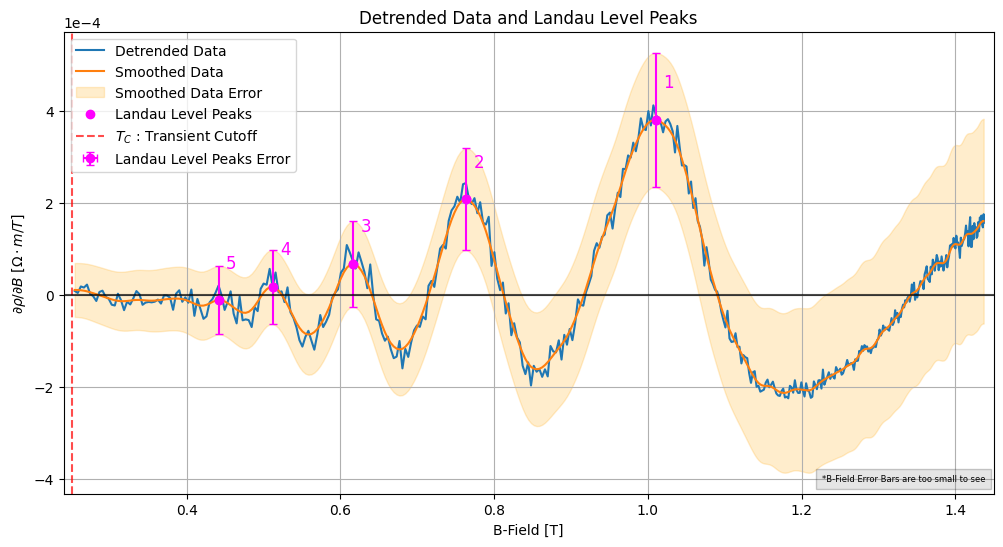

In [76]:

# Extract data
deline_field = avg_deline_data[avg_deline_data.columns[0]]
deline_volt = avg_deline_data[avg_deline_data.columns[1]]

deline_field_nom = unp.nominal_values(deline_field)
deline_volt_nom = unp.nominal_values(deline_volt)

deline_field_err = unp.std_devs(deline_field)
deline_volt_err = unp.std_devs(deline_volt)

# ==============================================================================

def gaussian_filter_uncert(data, sigma):
    nominal = unp.nominal_values(data)
    error = unp.std_devs(data)
    smoothed_nominal = gaussian_filter1d(nominal, sigma=sigma)
    smoothed_error = np.sqrt(gaussian_filter1d(error**2, sigma=sigma))
    return unp.uarray(smoothed_nominal, smoothed_error)

# Apply Gaussian filter
smoothed_voltage = gaussian_filter_uncert(deline_volt, sigma=3)
smoothed_voltage_nom = unp.nominal_values(smoothed_voltage)
smoothed_voltage_err = unp.std_devs(smoothed_voltage)

# ==============================================================================

# Find peaks
peaks_max = np.where(np.diff(np.sign(np.diff(smoothed_voltage))) == -2)[0] + 1
peak_field_max = deline_field[peaks_max]
peak_field_max_nom = unp.nominal_values(peak_field_max)
peak_field_max_err = unp.std_devs(peak_field_max)

peak_volt_max = smoothed_voltage[peaks_max]
peak_volt_max_nom = unp.nominal_values(peak_volt_max)
peak_volt_max_err = unp.std_devs(peak_volt_max)

# peaks_min = np.where(np.diff(np.sign(np.diff(smoothed_voltage))) == 2)[0] + 1
# peak_field_min = deline_field_nom[peaks_min]
# peak_field_min_nom = unp.nominal_values(peak_field_min)
# peak_field_min_err = unp.std_devs(peak_field_min)
# peak_voltage_min = smoothed_voltage[peaks_min]
# peak_voltage_min_nom = unp.nominal_values(peak_voltage_min)
# peak_voltage_min_err = unp.std_devs(peak_voltage_min)

landau_peak_field = peak_field_max[2:-4] # Remove the first two and last four peaks | These are not Landau levels
landau_peak_field = landau_peak_field[::-1].reset_index(drop=True)
landau_peak_field_nom = unp.nominal_values(landau_peak_field)
landau_peak_field_err = unp.std_devs(landau_peak_field)

landau_peak_volt = peak_volt_max[2:-4] # Remove the first two and last four peaks | These are not Landau levels
landau_peak_volt = landau_peak_volt[::-1]
landau_peak_volt_nom = unp.nominal_values(landau_peak_volt)
landau_peak_volt_err = unp.std_devs(landau_peak_volt)

# ==============================================================================

fig = plt.figure(figsize=(12, 6))

plt.plot(deline_field_nom, deline_volt_nom, label="Detrended Data")
plt.plot(deline_field_nom, smoothed_voltage_nom, label="Smoothed Data")
# plt.scatter(peak_field_max_nom, peak_volt_max_nom, color='orange', label="Peaks")
# plt.fill_between(deline_field_nom, deline_volt_nom - deline_volt_err, deline_volt_nom + deline_volt_err, color='b', alpha=0.2)
plt.fill_between(deline_field_nom, smoothed_voltage_nom - smoothed_voltage_err, smoothed_voltage_nom + smoothed_voltage_err, color='orange', label="Smoothed Data Error", alpha=0.2)

plt.scatter(landau_peak_field_nom, landau_peak_volt_nom, color='magenta', label="Landau Level Peaks")
plt.errorbar(landau_peak_field_nom, landau_peak_volt_nom, xerr=landau_peak_volt_err, yerr=landau_peak_volt_err, capsize=3, fmt='o', color='magenta', label="Landau Level Peaks Error")

for i in range(len(landau_peak_field)):
    plt.text(landau_peak_field_nom[i] + 1e-2, landau_peak_volt_nom[i] + 7e-5, f"{i + 1}", fontsize=12, color='magenta')

plt.axvline(transient_cutoff, color='r', ls='--', alpha=0.7, label=f"$T_C$ : Transient Cutoff")
plt.axhline(0, color='black', ls='-', alpha=0.7)

plt.text(0.815, 0.026, f"*B-Field Error Bars are too small to see", fontsize=6, transform=plt.gca().transAxes, bbox=dict(facecolor='grey', alpha=0.2))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlim(0.24, 1.45)
plt.xlabel("B-Field [T]")
plt.ylabel(r"$\partial{\rho} / \partial{B}$ $[\Omega \cdot m / T]$")
plt.title("Detrended Data and Landau Level Peaks")

plt.grid()
plt.legend()
# plt.savefig("detrended_data.png", dpi=800)
plt.show()


Known Effective Mass Ratio: 0.015
Known Optimal Frequency: 3.67566 THz
Calculated Effective Mass Ratio: 0.01496+/-0.00007
Fit: (1/B) = 0.3194+/-0.0015 * n + 0.670+/-0.005


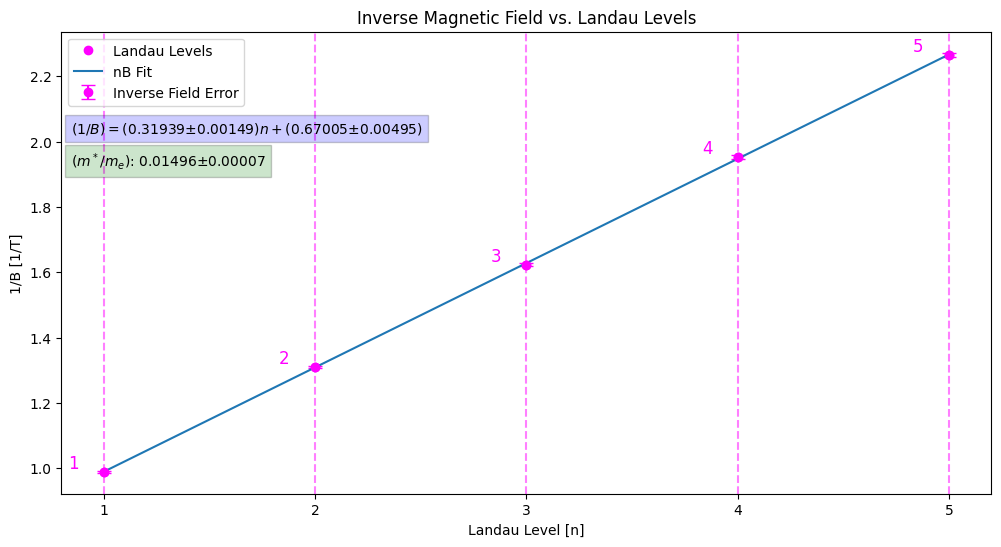

In [79]:
q_elec = 1.6e-19 # C
m_e = 9.11e-31 # kg
m_eff = 0.015 * m_e # kg | From Solid State Physics by Ashcroft and Mermin Pg. 570
w_opt = 2 * np.pi * (5.85e12) # | 5.85 THz is from Stradling's paper [R A Stradling 1972 J. Phys. E: Sci. Instrum. 5 736]

# Fit the n vs 1/B data

landau_peak_field_inv = 1/landau_peak_field
landau_peak_field_inv_nom = unp.nominal_values(landau_peak_field_inv)
landau_peak_field_inv_err = unp.std_devs(landau_peak_field_inv)
landau_num = range(1, len(landau_peak_field) + 1)

nB_fit, cov = np.polyfit(landau_num, landau_peak_field_inv_nom, 1, cov=True)
nB_fit_nom = unp.nominal_values(nB_fit)
nB_fit_err = np.sqrt(np.diag(cov))

nB_fit = unp.uarray(nB_fit, nB_fit_err)
nB_line_nom = unp.nominal_values(nB_fit[0] * np.array(landau_num) + nB_fit[1])
nB_fit_str = f"$(1/B) = ({nB_fit_nom[0]:.5f}$" + r"$\pm$" + f"${nB_fit_err[0]:.5f})n + ({nB_fit_nom[1]:.5f}$" + r"$\pm$" + f"${nB_fit_err[1]:.5f})$"

# Effective mass ratio
m_star = (q_elec / (nB_fit[0] * w_opt)) / m_e # dimensionless
m_star_nom = unp.nominal_values(m_star)
m_star_err = unp.std_devs(m_star)

print(f"Known Effective Mass Ratio: {0.015}")
print(f"Known Optimal Frequency: {(w_opt / 10e12):.5f} THz")

print(f"Calculated Effective Mass Ratio: {m_star:.5f}")

print(f"Fit: (1/B) = {nB_fit[0]} * n + {nB_fit[1]}")

# Plot 1/B vs n for the maxima
fig = plt.figure(figsize=(12, 6))

plt.plot(landau_num, landau_peak_field_inv_nom, 'o', color='magenta', label='Landau Levels') # Saw on a paper/book that it should be inverted
plt.errorbar(landau_num, landau_peak_field_inv_nom, yerr=landau_peak_field_inv_err, fmt='o', capsize=5, label='Inverse Field Error', color='magenta') # Error bars are too small to see
plt.plot(landau_num, nB_line_nom, linestyle='-', label='nB Fit')

for level in landau_num:
    plt.axvline(level, color='magenta', ls='--', alpha=0.5)
    plt.text(level - 0.17, landau_peak_field_inv_nom[level - 1] + 0.01, f"{level}", fontsize=12, color='magenta')

plt.text(0.01, 0.78, nB_fit_str, fontsize=10, transform=plt.gca().transAxes, bbox=dict(facecolor='b', alpha=0.2))
plt.text(0.01, 0.71, r"$(m^* / m_e)$" + f": {m_star_nom:.5f}" + r"$\pm$" + f"{m_star_err:.5f}", fontsize=10, transform=plt.gca().transAxes, bbox=dict(facecolor='g', alpha=0.2))
# plt.text(0.668, 0.07, f"*(1/B) Error Bars are too small to be seen thus they have been omitted", fontsize=6, transform=plt.gca().transAxes, bbox=dict(facecolor='grey', alpha=0.2))
plt.xticks(landau_num)

plt.ylabel('1/B [1/T]')
plt.xlabel('Landau Level [n]')
plt.title('Inverse Magnetic Field vs. Landau Levels')
plt.legend()
plt.savefig("landau_levels.png", dpi=800)
plt.show()

